# Continuous time series model for Stock Price prediction

A continuous time model is, in some ways, more fundamental than a discrete time
 model. For many variables, the process generating the observations can be
 regarded as a continuous one even though the observations themselves are only
 made at discrete intervals. Indeed a good deal of the theory in economics and
 other subjects is based on continuous time models.
 
 There are also strong statistical arguments for working with a continuous time
 model. Although missing observations can be handled by a discrete time model,
 irregularly spaced observations cannot. Formulating the model in continuous
 time provides the solution. Furthermore, even if the observations are at regular
 intervals, a continuous time model has the attraction of not being tied to the time
 interval at which the observations happen to be made.

In [1]:
# Import dependencies
import time
import math
import numpy as np
import pandas as pd
import datetime
import scipy as sc
from scipy.stats import norm
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from IPython.display import display, Latex
from statsmodels.graphics.tsaplots import plot_acf

In [4]:
!pip install yfinance

In [2]:
import yfinance as yf

In [3]:
# import data
def get_data(stocks, start, end):
    df = yf.download(tickers=stocks, start=start, end=end)
    return df

# endDate = datetime.datetime.now()
endDate=pd.to_datetime("2024-06-20 00:00:00")
print(endDate)
years=10
startDate = endDate - datetime.timedelta(days=years*365)
stock_prices = get_data('^GSPC', startDate, endDate)
print(startDate)
stock_prices

2024-06-20 00:00:00


[*********************100%***********************]  1 of 1 completed

2014-06-23 00:00:00


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2014-06-23,1962.609985,1962.609985,1963.739990,1958.890015,1962.920044,2717630000
2014-06-24,1949.979980,1949.979980,1968.170044,1948.339966,1961.969971,3089700000
2014-06-25,1959.530029,1959.530029,1960.829956,1947.489990,1949.270020,3106710000
2014-06-26,1957.219971,1957.219971,1959.890015,1944.689941,1959.890015,2778840000
2014-06-27,1960.959961,1960.959961,1961.469971,1952.180054,1956.560059,4290590000
...,...,...,...,...,...,...
2024-06-12,5421.029785,5421.029785,5447.250000,5409.129883,5409.129883,3962840000
2024-06-13,5433.740234,5433.740234,5441.930176,5402.509766,5441.930176,3530380000


In [6]:
df_tr = stock_prices[stock_prices.index < "2021-05-20"]
df_te = stock_prices[stock_prices.index >= "2021-05-20"]

### Continuous Time Autoregressive Model

  $\text{A continuous time white-noise process, $\xi(t)$, with mean zero and variance $\sigma^2$ is defined such that for $s > r$:}$
  
  ${\displaystyle \int_{r}^{s} \xi(t) dt = 0}$ 
  
  ${\displaystyle \int_{r}^{s} \xi(t) dt = (s-r)^2} $
  
  ${\displaystyle \int_{r}^{s} \xi(t)dt \int_{p}^{q} \xi(t) dt = 0, \quad r < s < p < q} $
  
  ${\displaystyle \int_{r}^{s} f(t)\xi(t) dt = 0}$
  
  ${\displaystyle \int_{r}^{s} f(t)\xi(t) dt = \sigma^2 \int_{r}^{s} f^2(t) dt}$
  
  ${\displaystyle \int_{r}^{s} f(t)\xi(t) dt \int_{r}^{s} g(t)\xi(t) dt = \sigma^2 \int_{r}^{s} f(t)g(t) dt}$
  
  Using the above definition of continuous time white noise, a first-order con
tinuous time process can be represented as the stochastic differential equation:
  
  ${\displaystyle (d/dt)y(t) = \gamma + \alpha y(t) + \xi(t)}$
  
  $ y(t) - y(0) = \int_0^t \left[\gamma + \alpha y(r)\right] dr + \int_0^t \xi(r) dr $
  
  $ y(t) = \left[y(0) + \frac{\gamma}{\alpha}\right]e^{\alpha t} - \frac{\gamma}{\alpha} + \int_0^t e^{\alpha(t-r)}\xi(r) dr $
  
 $y(t) = \left[e^{\alpha t} - 1\right]\frac{\gamma}{\alpha} + e^{\alpha t}y(t-1) + \int_0^t e^{\alpha(t-r)}\xi(r) dr $
 
 $ y_t = \theta + \phi y_{t-1} + \epsilon_t, \quad t = 1,\ldots,T $
 
 $ text{where} $
 
 $\phi = \exp(\alpha) $
 
 $\theta = \left(e^{\alpha} - 1\right)\frac{\gamma}{\alpha} $

 $\operatorname{Var}(\epsilon_t) = \sigma^2\left(e^{2\alpha} - 1\right)/2\alpha$

In [7]:
df = df_tr[["Adj Close"]].copy()
df["Adj Close.shift"] = df_tr["Adj Close"].shift(1)

In [8]:
df.dropna(inplace=True)
df.head()

Price,Adj Close,Adj Close.shift
Ticker,^GSPC,
Date,,
2014-06-24,1949.979980,1962.609985
2014-06-25,1959.530029,1949.979980
2014-06-26,1957.219971,1959.530029
2014-06-27,1960.959961,1957.219971
2014-06-30,1960.229980,1960.959961


In [9]:
y_t_1 = df[["Adj Close.shift"]].values
y_t = df["Adj Close"].values

In [10]:
y_t_1

array([[1962.60998535],
       [1949.97998047],
       [1959.5300293 ],
       ...,
       [4173.85009766],
       [4163.29003906],
       [4127.83007812]])

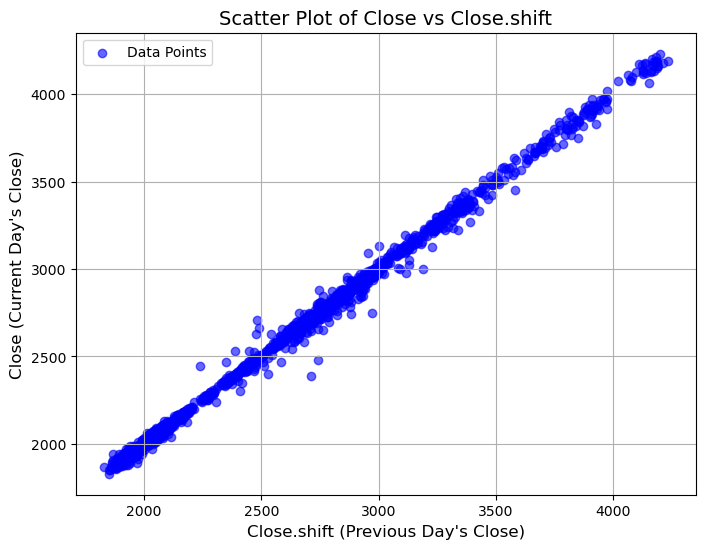

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(y_t_1, y_t, color='blue', alpha=0.6, label='Data Points')
plt.title("Scatter Plot of Close vs Close.shift", fontsize=14)
plt.xlabel("Close.shift (Previous Day's Close)", fontsize=12)
plt.ylabel("Close (Current Day's Close)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [12]:
y_t_1_mean = y_t_1.mean()
y_t_mean = y_t.mean()

# Calculate phi (slope)
phi = np.sum((y_t_1 - y_t_1_mean) * (y_t - y_t_mean)) / np.sum((y_t_1 - y_t_1_mean)**2)

# Calculate theta (intercept)
theta = y_t_mean - phi * y_t_1_mean

# Print parameters
print(f"Estimated theta (intercept): {theta}")
print(f"Estimated phi (slope): {phi}")

Estimated theta (intercept): 0.7025875804529278
Estimated phi (slope): 1.0002051680191515


In [13]:
y_pred = theta + phi * y_t_1
error = y_pred - y_t

In [14]:
error_mean = np.mean(error)
error_std = np.std(error)

In [15]:
alpha = np.log(phi)
gamma = (theta * alpha) / (np.exp(alpha) - 1)
residual_variance = np.var(error, ddof=1)  # Variance of residuals
sigma_squared = (residual_variance * 2 * alpha) / (np.exp(2 * alpha) - 1)
sigma = np.sqrt(sigma_squared)  # Standard deviation


In [16]:
y_initial = df["Adj Close"].iloc[-1]

In [17]:
y_pred = np.zeros((504, 1000))
y_pred[:][0] = y_initial

In [18]:
y_pred

array([[4115.68017578, 4115.68017578, 4115.68017578, ..., 4115.68017578,
        4115.68017578, 4115.68017578],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

In [19]:
for m in range(1000):
  for i in range(1, 504):
    y_pred[i][m] = theta + phi * y_pred[i - 1][m] + np.random.normal(0, error_std)

In [20]:
y_pred

array([[4115.68017578, 4115.68017578, 4115.68017578, ..., 4115.68017578,
        4115.68017578, 4115.68017578],
       [4175.70834449, 4072.57637843, 4114.64110952, ..., 4132.18168395,
        4129.61481818, 4155.13807628],
       [4219.08927767, 4036.23497458, 4121.72134711, ..., 4177.30091727,
        4101.15052813, 4185.03459585],
       ...,
       [4870.19833408, 5213.12123923, 4752.18469161, ..., 4372.35807607,
        5779.4246639 , 5839.09310846],
       [4830.51216874, 5227.86354341, 4778.26670892, ..., 4388.58160339,
        5775.44451865, 5838.3406861 ],
       [4835.20967736, 5246.79452607, 4829.82905463, ..., 4399.14705503,
        5804.68568155, 5858.45946244]])

In [22]:
dates = pd.date_range(start="2021-05-20", periods=504, freq="B")

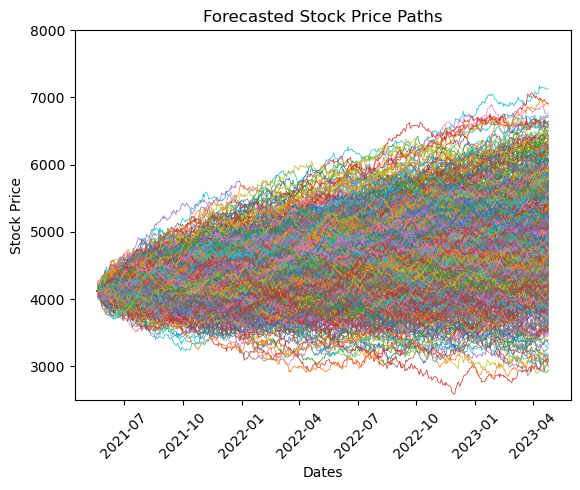

In [23]:
plt.plot(dates, y_pred, linewidth = 0.5)
plt.title("Forecasted Stock Price Paths")
plt.xlabel("Dates")
plt.xticks(rotation =45)
plt.ylabel("Stock Price")
plt.ylim(2500, 8000)
plt.show()

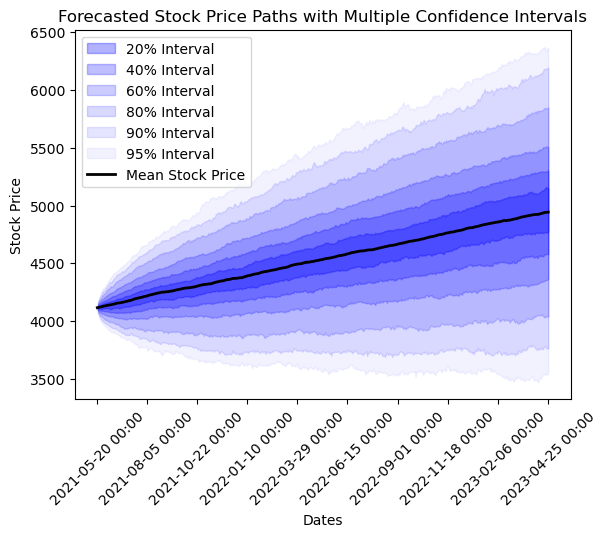

In [24]:
intervals = [20, 40, 60, 80, 90, 95]  # Confidence intervals to plot
base_color = "blue"  # Base color for all intervals
alpha_values = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05]  # Increasing transparency for larger intervals

# Plot multiple confidence intervals
for i, interval in enumerate(intervals):
    lower_bound = np.percentile(y_pred, (100 - interval) / 2, axis=1)
    upper_bound = np.percentile(y_pred, 100 - (100 - interval) / 2, axis=1)
    plt.fill_between(range(y_pred.shape[0]), lower_bound, upper_bound,
                     color=base_color, alpha=alpha_values[i], label=f"{interval}% Interval")

# Plot the mean stock price
mean_values = np.mean(y_pred, axis=1)
plt.plot(mean_values, color="black", label="Mean Stock Price", linewidth=2)

# Add labels, title, and legend
plt.title("Forecasted Stock Price Paths with Multiple Confidence Intervals")
plt.xlabel("Dates")
plt.xticks(rotation=45)
plt.ylabel("Stock Price")
plt.legend(loc="upper left")  # Move legend to the top-left corner
plt.xticks(
    ticks=np.linspace(0, len(dates) - 1, 10, dtype=int),  # Add ticks at equal intervals
    labels=pd.Series(dates).iloc[
        np.linspace(0, len(dates) - 1, 10, dtype=int)
    ].dt.strftime("%Y-%m-%d %H:%M"),  # Format ticks as datetime
    rotation=45
)
plt.show()

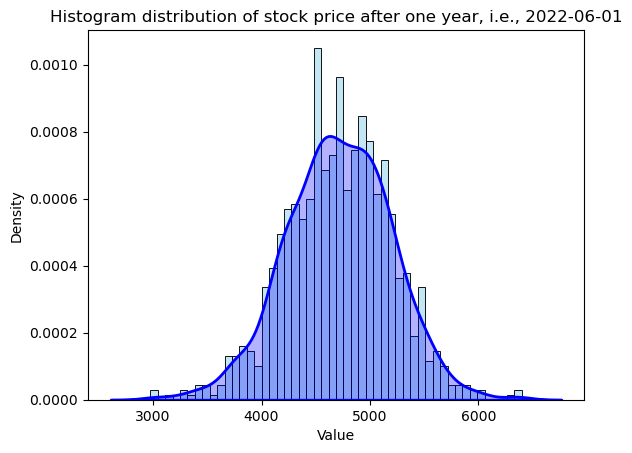

In [25]:
import seaborn as sns
sns.histplot(y_pred[251], bins=50, kde=False, stat="density", color="skyblue", alpha=0.5)
sns.kdeplot(y_pred[251], color="blue", linewidth=2, fill=True, alpha=0.3)

plt.title("Histogram distribution of stock price after one year, i.e., 2022-06-01")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

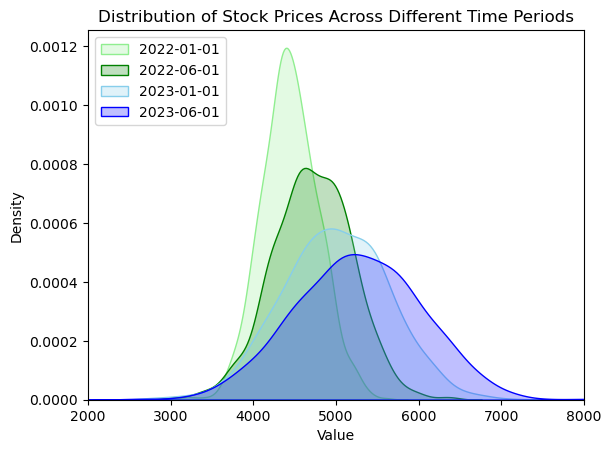

In [26]:

sns.kdeplot(y_pred[125], color="lightgreen", linewidth=1, fill=True, label = "2022-01-01")
sns.kdeplot(y_pred[251], color="green", linewidth=1, fill=True, label = "2022-06-01")
sns.kdeplot(y_pred[377], color="skyblue", linewidth=1, fill=True, label = "2023-01-01")
sns.kdeplot(y_pred[503], color="blue", linewidth=1, fill=True, label = "2023-06-01")
plt.legend(loc="upper left", fontsize=10)
plt.title("Distribution of Stock Prices Across Different Time Periods")
plt.xlim(2000,8000)
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

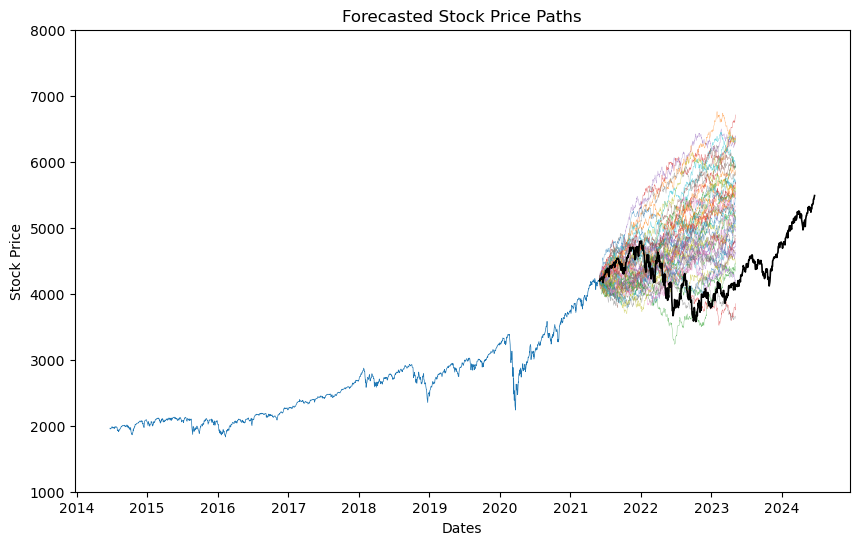

In [43]:
plt.figure(figsize=(10, 6))
for j in range(50):
  plt.plot(dates, y_pred[:, j], alpha=0.6, linewidth=0.3)

plt.plot(df_tr["Adj Close"], linewidth=0.5)
plt.plot(df_te["Adj Close"], linewidth=1.2, color = "Black")
plt.title("Forecasted Stock Price Paths")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.ylim(1000, 8000)
plt.show()

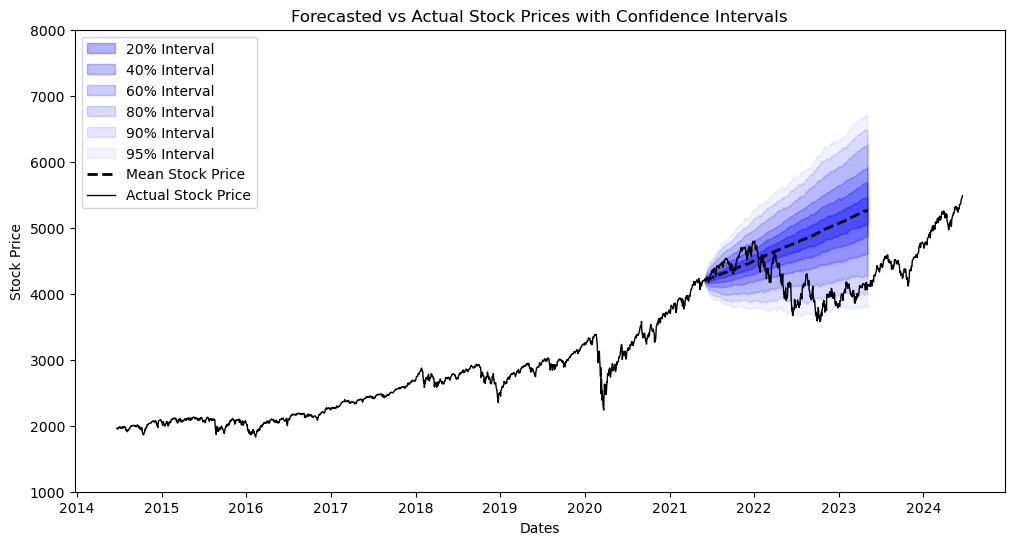

In [44]:
intervals = [20, 40, 60, 80, 90, 95]  # Confidence intervals to plot
base_color = "blue"  # Base color for all intervals
alpha_values = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05]  # Increasing transparency for larger intervals

plt.figure(figsize=(12, 6))

# Plot confidence intervals for simulated data
for i, interval in enumerate(intervals):
    lower_bound = np.percentile(y_pred, (100 - interval) / 2, axis=1)
    upper_bound = np.percentile(y_pred, 100 - (100 - interval) / 2, axis=1)
    plt.fill_between(
        dates,  # X-axis range
        lower_bound,
        upper_bound,
        color=base_color,
        alpha=alpha_values[i],
        label=f"{interval}% Interval"
    )

# Plot the mean stock price
mean_values = np.mean(y_pred, axis=1)
plt.plot(dates,mean_values, color="black", label="Mean Stock Price",linestyle = "--", linewidth=2)

# Plot actual stock prices
plt.plot(stock_prices["Close"], color="black", label="Actual Stock Price", linewidth=1)

# Add labels, title, and legend
plt.title("Forecasted vs Actual Stock Prices with Confidence Intervals")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend(loc="upper left")
plt.ylim(1000,8000)

# Format x-axis with datetime ticks

# Display the plot
plt.show()

## Weekly Stock Price Forecast

################################################################################################################################################################

In [45]:
df_tr2 = stock_prices[stock_prices.index < "2024-10-28"]

In [46]:
df2 = df_tr2[["Close"]].copy()
df2["Close.shift"] = df_tr2["Close"].shift(1)
df2.dropna(inplace=True)
df2.head()
y_t_1d = df2[["Close.shift"]].values
y_td = df2["Close"].values
y_t_1dmean = y_t_1d.mean()
y_tdmean = y_td.mean()

# Calculate phi (slope)
phi_d = np.sum((y_t_1d - y_t_1dmean) * (y_td - y_tdmean)) / np.sum((y_t_1d - y_t_1dmean)**2)

# Calculate theta (intercept)
theta_d = y_tdmean - phi_d * y_t_1dmean

y_pred_d = theta_d + phi_d * y_t_1d
error_d = y_pred_d - y_td
error_mean_d = np.mean(error_d)
error_std_d = np.std(error_d)

alpha_d = np.log(phi_d)
gamma_d = (theta_d * alpha_d) / (np.exp(alpha_d) - 1)
residual_variance_d = np.var(error_d, ddof=1)  # Variance of residuals
sigma_squared_d = (residual_variance_d * 2 * alpha_d) / (np.exp(2 * alpha_d) - 1)
sigma_d = np.sqrt(sigma_squared_d)  # Standard deviation



In [47]:
stock_prices.tail(10)

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2024-06-05,5354.029785,5354.029785,5354.160156,5297.640137,5314.479980,3591460000
2024-06-06,5352.959961,5352.959961,5362.350098,5335.359863,5357.799805,3609990000
2024-06-07,5346.990234,5346.990234,5375.080078,5331.330078,5343.810059,3692760000
2024-06-10,5360.790039,5360.790039,5365.790039,5331.520020,5341.220215,3622280000
2024-06-11,5375.319824,5375.319824,5375.950195,5327.250000,5353.000000,3568030000
2024-06-12,5421.029785,5421.029785,5447.250000,5409.129883,5409.129883,3962840000
2024-06-13,5433.740234,5433.740234,5441.930176,5402.509766,5441.930176,3530380000
2024-06-14,5431.600098,5431.600098,5432.390137,5403.750000,5424.080078,3438650000


In [48]:
y_pred_d = np.zeros((75, 100))
y_pred_d[:][0] = stock_prices[stock_prices.index == "2024-06-10"]["Adj Close"]

In [49]:
y_pred_d

array([[5360.79003906, 5360.79003906, 5360.79003906, ..., 5360.79003906,
        5360.79003906, 5360.79003906],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

In [50]:
dates_week = pd.date_range(start="2024-06-10", end="2024-06-14", freq="B")

date_range = pd.concat(
    [pd.Series(pd.date_range(start=day + pd.Timedelta(hours=9), end=day + pd.Timedelta(hours=16), freq="30T")) for day in dates_week],
)

In [51]:

date_index = np.arange(len(date_range))
len(date_index)

75

In [52]:
dt = 1/75
phi_t = np.exp(alpha_d*dt)
theta_t = (np.exp(alpha_d*dt)-1)*gamma_d/alpha_d
var_t = sigma_squared_d*(np.exp(2 * alpha_d * dt) - 1)/(2*alpha_d)
for m in range(0, 100):
  for i in range(1, 75):
    y_pred_d[i][m] = theta_t + phi_t * y_pred_d[i - 1][m] + np.random.normal(0, np.sqrt(var_t))

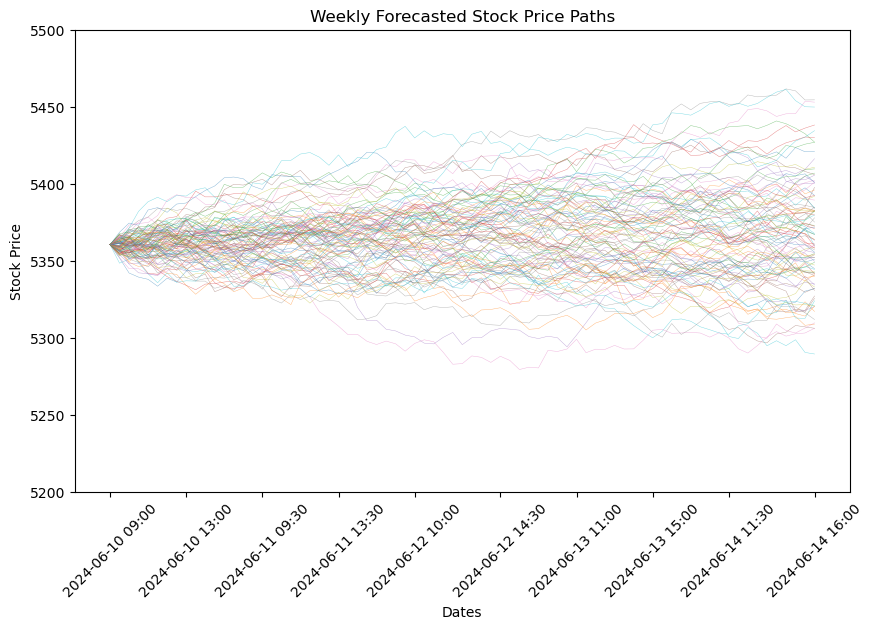

In [54]:

plt.figure(figsize=(10, 6))
for j in range(100):
  plt.plot(date_index, y_pred_d[:, j], alpha=0.6, linewidth=0.3)
  plt.xticks(
    ticks=np.linspace(0, len(date_index) - 1, 10, dtype=int),  # Add ticks at equal intervals
    labels=pd.Series(date_range).iloc[
        np.linspace(0, len(date_range) - 1, 10, dtype=int)
    ].dt.strftime("%Y-%m-%d %H:%M"),  # Format ticks as datetime
    rotation=45
)

plt.title("Weekly Forecasted Stock Price Paths")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.ylim(5200, 5500)
plt.show()

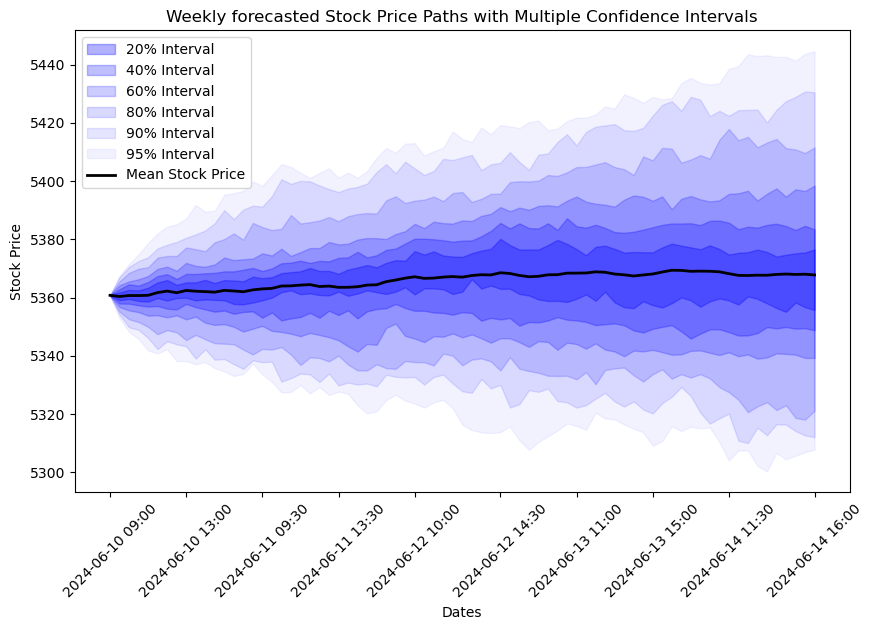

In [56]:
intervals = [20, 40, 60, 80, 90, 95]  # Confidence intervals to plot
base_color = "blue"  # Base color for all intervals
alpha_values = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05]  # Increasing transparency for larger intervals
plt.figure(figsize=(10, 6))
for i, interval in enumerate(intervals):
    lower_bound = np.percentile(y_pred_d, (100 - interval) / 2, axis=1)
    upper_bound = np.percentile(y_pred_d, 100 - (100 - interval) / 2, axis=1)
    plt.fill_between(
        date_index,  # X-axis range
        lower_bound,
        upper_bound,
        color=base_color,
        alpha=alpha_values[i],
        label=f"{interval}% Interval"
    )

# Plot the mean stock price
mean_values_d = np.mean(y_pred_d, axis=1)
plt.plot(date_index, mean_values_d, color="black", label="Mean Stock Price", linewidth=2)

# Add labels, title, and legend
plt.title("Weekly forecasted Stock Price Paths with Multiple Confidence Intervals")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.xticks(
    ticks=np.linspace(0, len(date_index) - 1, 10, dtype=int),  # Add ticks at equal intervals
    labels=pd.Series(date_range).iloc[
        np.linspace(0, len(date_range) - 1, 10, dtype=int)
    ].dt.strftime("%Y-%m-%d %H:%M"),  # Format ticks as datetime
    rotation=45
)
plt.legend(loc="upper left")  # Move legend to the top-left corner
plt.show()